In [101]:
#from scipy import stats
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
#from scipy.optimize import curve_fit
#%matplotlib inline
# Suppress warnings. Comment this out if you wish to see the warning messages
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from tqdm import tqdm
import corner

10.127570981578367 3.0601552835620844


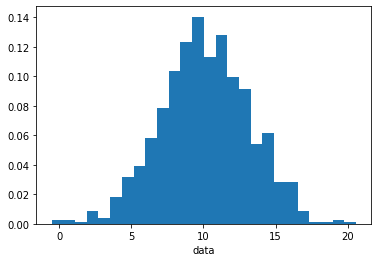

In [102]:
N = 1000
data = np.random.normal(loc=10, scale=3.0, size=N) + np.random.uniform(-1,1,N)#np.random.random(N)

bin_heights, bin_borders, _ = plt.hist(data, bins='auto',range=(min(data),max(data)),density=True)
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
plt.xlabel('data')
print(np.mean(data),np.std(data))

In [103]:
def log_likelihood(params, x):
    std, mu = params
    Ac = -0.5*((x - mu)/std)**2
    y = 1/(np.sqrt(2 * np.pi * std**2)) * np.exp( Ac )
    # Calculate log likelihood
    return np.sum(np.log(y))

# def log_likelihood(params, x):
#     std, mu = params
#     # Calculate negative log likelihood
#     N = len(x)
#     return -0.5 * N * np.log(2 * np.pi) - N * np.log(std) - 0.5* np.sum(((x - mu)/std)**2)

def log_prior(params):
    std, mu = params
    if 0.0 < std < 10.0 and 0.0 < mu < 20.0:
        return 0.0
    return -np.inf

def log_probability(params, x):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, x)

In [104]:
sample_data = data
std, mu = np.std(sample_data), np.mean(sample_data)
initparams = [std, mu]
print(initparams)
print(log_likelihood(initparams, sample_data))
print(log_prior(initparams))
print(log_probability(initparams, sample_data))

nll = lambda *args: -log_likelihood(*args)

results = minimize(nll, initparams, args=(sample_data), options={"disc":True}, method='Nelder-Mead')
results.x

[3.0601552835620844, 10.127570981578367]
-2537.404194143533
0.0
-2537.404194143533


array([ 3.06015528, 10.12757098])

In [105]:
def Metropolis(params, data, a = 0.1, NSteps = int(3e4)):
    x = np.ones(( NSteps, len(params) ))
    x[0] = params
    #x[0] = [np.random.rand(),np.random.rand(),np.random.rand(),np.random.rand(),np.random.rand()]
    
    for i in tqdm(range(1, NSteps)):
        std = x[i-1,0] + a * np.random.normal(loc=0, scale=1.0)
        mu = x[i-1,1] + a * np.random.normal(loc=0, scale=1.0)
        
        #present = log_likelihood(params) + log_prior(params)
        #future = log_likelihood([std, mu]) + log_prior([std, mu])
        present = log_probability(params, data)
        future = log_probability([std, mu], data)

        alpha = np.minimum(1, np.exp( future - present ))
        g = np.random.rand()
        
        if alpha > g:
            x[i,0] = std
            x[i,1] = mu
        else:
            x[i,:] = x[i-1,:]       
         
    return x[100:,:] # quemamos los primeros xxxx puntos

In [106]:
initparams = results.x
MCMC = Metropolis(initparams, sample_data, 0.1, 100000)

100%|██████████| 99999/99999 [00:12<00:00, 7735.82it/s]


Minimize: [ 3.06015528 10.12757098]
MCMC:     [ 3.06311035 10.12902315]


Text(0.5, 0, 'step number')

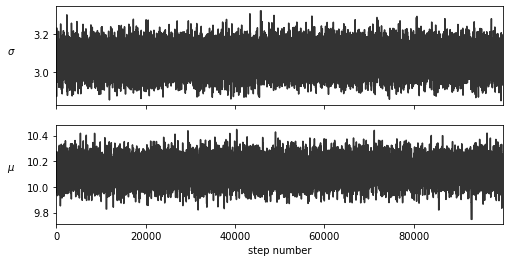

In [107]:
params_mcmc = np.percentile(MCMC ,50, axis=0)
print('Minimize:',results.x)
print('MCMC:    ',params_mcmc)

fig, axes = plt.subplots(len(params_mcmc), figsize=(8, 4), sharex=True)
labels = ["$\sigma$", "$\mu$"]
for i in range(len(params_mcmc)):
    ax = axes[i]
    ax.plot(MCMC[:,i], 'k', alpha=0.8)
    ax.set_xlim(0, len(MCMC))
    ax.set_ylabel(labels[i], rotation=0)
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number")

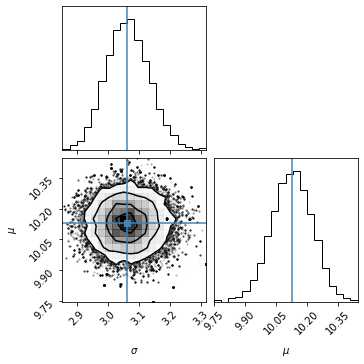

In [108]:
truths = np.percentile(MCMC ,50, axis=0)
labels = ["$\sigma$", "$\mu$"]

figure = corner.corner(MCMC, labels=labels, truths=truths)

(80703, 20)


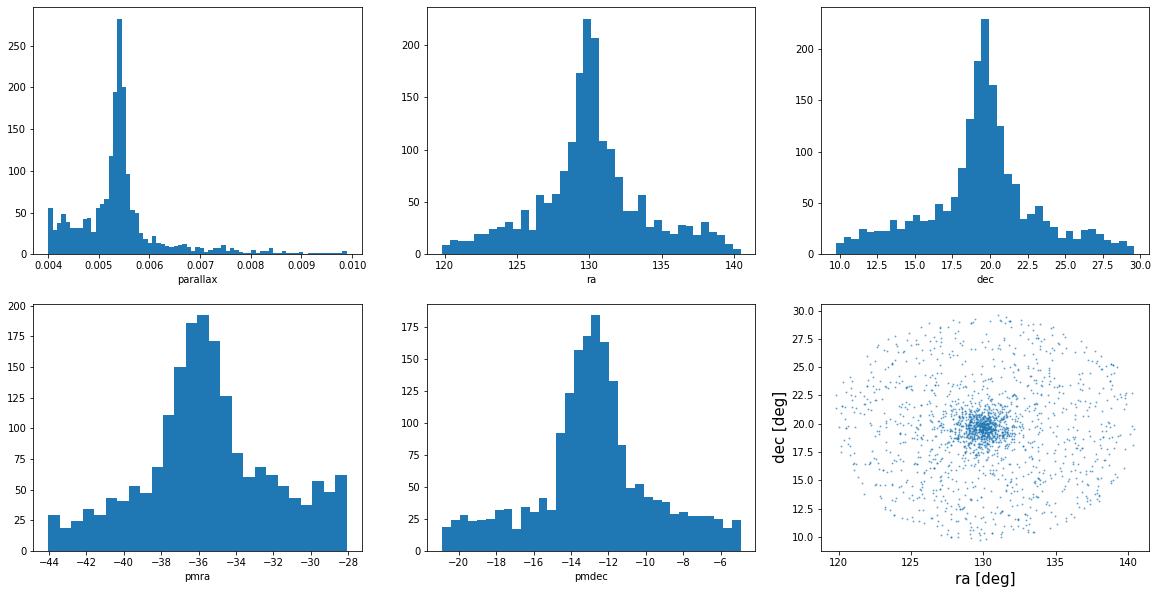

1893


In [126]:
df = pd.read_csv('./beehive_10.csv')
#df.loc[df['ra'] > 300, 'ra'] -= 360 #SOLO PARA BLANCO 1
df = df.fillna(0)
df['parallax'] = df['parallax'] / 1000
df['parallax_error'] = df['parallax_error'] / 1000
print(df.shape)

mu_alpha, mu_delta = -36.047, -12.917
rango = 8
c_pm=(df['pmra'] > mu_alpha - rango) & (df['pmra'] < mu_alpha + rango) & \
                        (df['pmdec'] > mu_delta - rango) & (df['pmdec'] < mu_delta + rango)
c_p = (df['parallax'] > 0.004) & (df['parallax'] < 0.01)

df = df[c_pm & c_p]

plt.figure(figsize=(20,10))

plt.subplot(2,3,1)
plt.hist(df.parallax,bins='auto')
plt.xlabel('parallax')

plt.subplot(2,3,2)
plt.hist(df.ra,bins='auto')
plt.xlabel('ra')

plt.subplot(2,3,3)
plt.hist(df.dec,bins='auto')
plt.xlabel('dec')

plt.subplot(2,3,4)
plt.hist(df.pmra,bins='auto')
#plt.xlim(-100,100)
plt.xlabel('pmra')

plt.subplot(2,3,5)
plt.hist(df.pmdec,bins='auto')
#plt.xlim(-100,100)
plt.xlabel('pmdec')

plt.subplot(2,3,6)
plt.scatter(df['ra'], df['dec'], marker='o' , s=1, alpha = 0.5)
plt.xlabel("ra [deg]",  fontsize = 15)
plt.ylabel("dec [deg]",  fontsize = 15)#,rotation=0)
#plt.xlim(-30,0)
#plt.ylim(0,30)
plt.show()

print(len(df))

In [ ]:
# nwalkers, ndim = 250, 2
# #p0 = [results_pmra.x + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
# p0 = results_pmra.x * np.random.randn(nwalkers, ndim)
# #p0 = [np.random.rand(ndim) for i in range(nwalkers)]

# import emcee
# sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=[sample_data])
# pos, prob, state = sampler.run_mcmc(p0, 5000, progress=True)

# #samples = sampler.chain
# samples = sampler.get_chain()
# labels = ["$\sigma$", "$\mu$"]
# fig, axes = plt.subplots(ndim, figsize=(8, 4), sharex=True)
# for i in range(ndim):
#     ax = axes[i]
#     ax.plot(samples[:, :, i], "k", alpha=0.2)
#     #ax.plot(pos[:, i], "k", alpha=0.3)
#     ax.set_xlim(0, len(samples))
#     ax.set_ylabel(labels[i], rotation=0)
#     ax.yaxis.set_label_coords(-0.1, 0.5)
# axes[-1].set_xlabel("step number")

# tau = sampler.get_autocorr_time()
# print(tau)
# flat_samples = sampler.get_chain(discard=50, flat=True)
# print(flat_samples.shape)

# maxprob_indice = np.argmax(prob)
# sigma_fit, mean_fit = pos[maxprob_indice]

# import corner
# fig = corner.corner(flat_samples, labels=labels, truths=[sigma_fit, mean_fit])

# Two Gaussian functions

In [185]:
def log_likelihood(params, x):
    nc, sc, sf, mu_c, mu_f = params
    Ac = -0.5*((x - mu_c)/sc)**2
    Be = -0.5*((x - mu_f)/sf)**2
    y = nc/(np.sqrt(2*np.pi)*sc)*np.exp(Ac) + (1-nc)/(np.sqrt(2*np.pi)*sf)*np.exp(Be)
    # Calculate log likelihood
    return np.sum(np.log(y))

def log_prior(params):
    nc, sc, sf, mu_c, mu_f = params
    if 0.0 < nc < 1.0 and 0.0 < sc < 10.0 and 0.0 < sf < 10.0:
        return 0.0
    return -np.inf

def log_probability(params, x):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, x)

def gaussian_function(x, params):
    nc, sc, sf, mu_c, mu_f = params
    Ac = -0.5*((x - mu_c)/sc)**2
    Be = -0.5*((x - mu_f)/sf)**2
    return nc/(np.sqrt(2*np.pi)*sc)*np.exp(Ac) + (1-nc)/(np.sqrt(2*np.pi)*sf)*np.exp(Be)

In [186]:
sample_data = df.pmra
sc, sf = np.std(sample_data)/2, np.std(sample_data)
mu_c, mu_f = np.mean(sample_data), np.mean(sample_data)
initparams_pmra = [0.5, sc, sf, mu_c, mu_f]
print(log_likelihood(initparams_pmra, sample_data))
print(log_prior(initparams_pmra))
print(log_probability(initparams_pmra, sample_data))

nll = lambda *args: -log_likelihood(*args)

results_pmra = minimize(nll, initparams_pmra, args=(sample_data), options={"disc":True}, method='Nelder-Mead')
results_pmra.x

-5139.723127083209
0.0
-5139.723127083209


array([  0.22115376,   0.87281115,   3.93922786, -35.99260613,
       -35.36842134])

In [187]:
sample_data = df.pmdec
sc, sf = np.std(sample_data)/2, np.std(sample_data)
mu_c, mu_f = np.mean(sample_data), np.mean(sample_data)
initparams_pmdec = [0.5, sc, sf, mu_c, mu_f]
print(log_likelihood(initparams_pmdec, sample_data))
print(log_prior(initparams_pmdec))
print(log_probability(initparams_pmdec, sample_data))

nll = lambda *args: -log_likelihood(*args)

results_pmdec = minimize(nll, initparams_pmdec, args=(sample_data), options={"disc":True}, method='Nelder-Mead')
results_pmdec.x

-4909.549560050082
0.0
-4909.549560050082


array([  0.34087998,   0.90488743,   3.92582596, -12.87465234,
       -12.75674254])

Text(0.5, 0, 'pmdec')

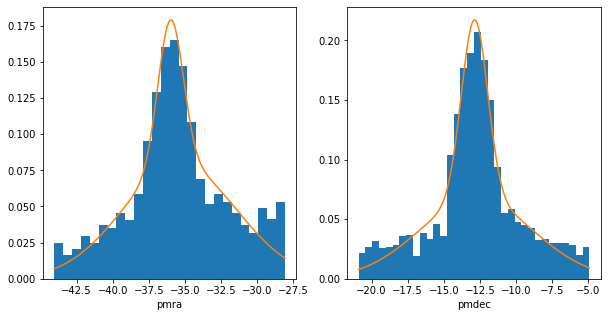

In [188]:
plt.figure(figsize=(10,5))
sample_data = df.pmra
plt.subplot(1,2,1)
bin_heights, bin_borders, _ = plt.hist(sample_data, bins='auto',
                                       range=(min(sample_data),max(sample_data)),density=True)
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
x = np.linspace(bin_borders[0], bin_borders[-1], 10000)
plt.plot(x, gaussian_function(x, results_pmra.x))
plt.xlabel('pmra')

plt.subplot(1,2,2)
sample_data = df.pmdec
bin_heights, bin_borders, _ = plt.hist(sample_data, bins='auto',
                                       range=(min(sample_data),max(sample_data)),density=True)
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
x = np.linspace(bin_borders[0], bin_borders[-1], 10000)
plt.plot(x, gaussian_function(x, results_pmdec.x))
plt.xlabel('pmdec')

In [189]:
def Metropolis(params, data, a = 0.1, NSteps = int(3e4)):
    
    x = np.ones(( NSteps, len(params) ))
    x[0] = params
    #x[0] = [np.random.rand(),np.random.rand(),np.random.rand(),np.random.rand(),np.random.rand()]
    
    for i in tqdm(range(1, NSteps)):
        nc = x[i-1,0] + a * np.random.normal(loc=0, scale=1.0)
        sc = x[i-1,1] + a * np.random.normal(loc=0, scale=1.0)
        sf = x[i-1,2] + a * np.random.normal(loc=0, scale=1.0)
        mu_c = x[i-1,3] + a * np.random.normal(loc=0, scale=1.0)
        mu_f = x[i-1,4] + a * np.random.normal(loc=0, scale=1.0)
        
        present = log_probability(params, data)
        future = log_probability([nc,sc,sf,mu_c,mu_f], data)

        alpha = np.minimum(1, np.exp( future - present ))
        g = np.random.rand() 
        
        if alpha > g:
            x[i,0] = nc
            x[i,1] = sc
            x[i,2] = sf
            x[i,3] = mu_c
            x[i,4] = mu_f
        else:
            x[i,:] = x[i-1,:]       
         
    return x[100:,:] # burn-in the first xxxx points

In [190]:
sample_data = df.pmra
initparams = results_pmra.x
MCMC_pmra = Metropolis(initparams, sample_data, 0.01, 500000)

100%|██████████| 499999/499999 [30:09<00:00, 276.34it/s]  


Minimize: [  0.22115376   0.87281115   3.93922786 -35.99260613 -35.36842134]
MCMC:     [  0.21786687   0.87832385   3.92245432 -35.98747936 -35.37684089]


Text(0.5, 0, 'step number')

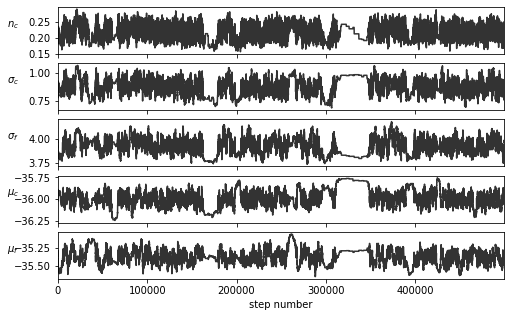

In [191]:
params_mcmc_pmra = np.percentile(MCMC_pmra ,50, axis=0)
print('Minimize:',results_pmra.x)
print('MCMC:    ',params_mcmc_pmra)

fig, axes = plt.subplots(len(params_mcmc_pmra), figsize=(8, 5), sharex=True)
labels = ["$n_c$", "$\sigma_c$", "$\sigma_f$", "$\mu_c$", "$\mu_f$"]
for i in range(len(params_mcmc_pmra)):
    ax = axes[i]
    ax.plot(MCMC_pmra[:,i], "k", alpha=0.8)
    ax.set_xlim(0, len(MCMC_pmra))
    ax.set_ylabel(labels[i],rotation=0)
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number")

In [25]:
# q1 = np.quantile(MCMC, q=[0.16,0.84],axis=0)
# errorsup = q1[1] -params_mcmc_pmra
# errorinf = params_mcmc_pmra - q1[0]
# print(errorsup)
# print(errorinf)
# print(results_pmra.x)

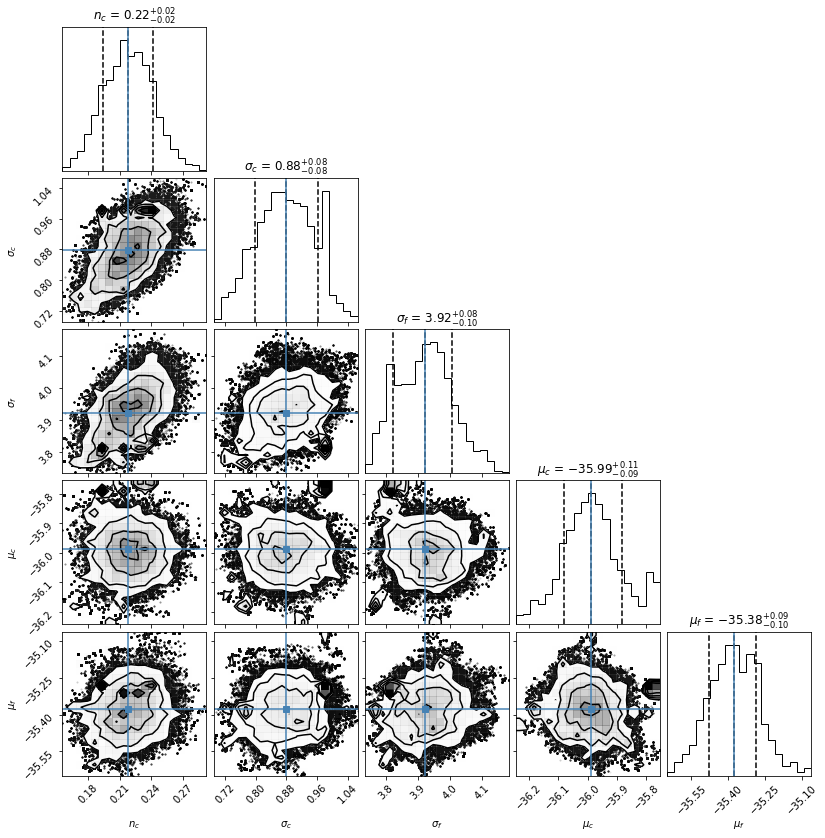

In [192]:
truths = np.percentile(MCMC_pmra ,50, axis=0)
labels = ["$n_c$", "$\sigma_c$", "$\sigma_f$", "$\mu_c$", "$\mu_f$"]

figure = corner.corner(MCMC_pmra, labels=labels, truths=truths, quantiles=[0.16, 0.5, 0.84], show_titles=True,
                      title_kwargs={"fontsize": 12})

In [193]:
sample_data = df.pmdec
initparams = results_pmdec.x
MCMC_pmdec = Metropolis(initparams, sample_data, 0.005, 500000)

100%|██████████| 499999/499999 [29:59<00:00, 277.86it/s]  


Minimize: [  0.34087998   0.90488743   3.92582596 -12.87465234 -12.75674254]
MCMC:     [  0.34105352   0.9067968    3.92970635 -12.88103477 -12.74423177]


Text(0.5, 0, 'step number')

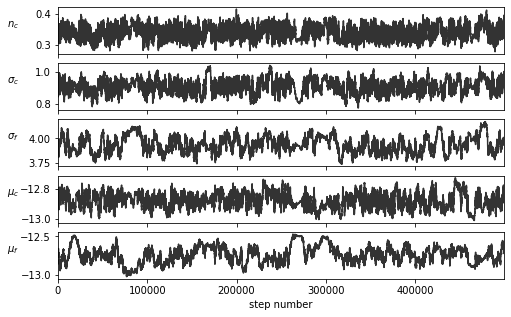

In [194]:
params_mcmc_pmdec = np.percentile(MCMC_pmdec ,50, axis=0)
print('Minimize:',results_pmdec.x)
print('MCMC:    ',params_mcmc_pmdec)

fig, axes = plt.subplots(len(params_mcmc_pmdec), figsize=(8, 5), sharex=True)
labels = ["$n_c$", "$\sigma_c$", "$\sigma_f$", "$\mu_c$", "$\mu_f$"]
for i in range(len(params_mcmc_pmdec)):
    ax = axes[i]
    ax.plot(MCMC_pmdec[:,i], "k", alpha=0.8)
    ax.set_xlim(0, len(MCMC_pmdec))
    ax.set_ylabel(labels[i],rotation=0)
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number")

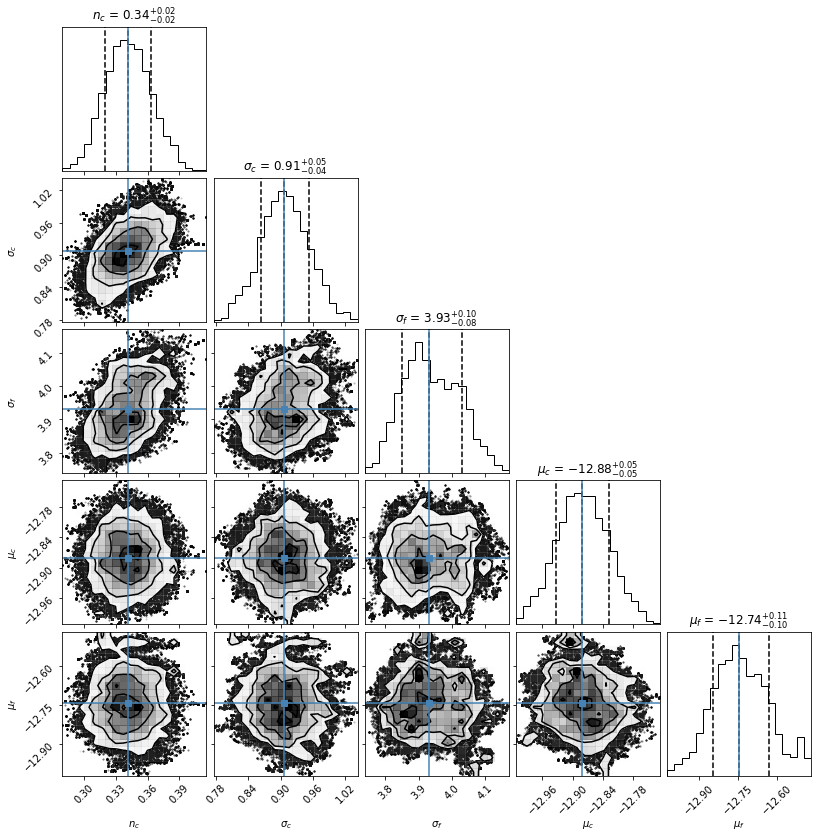

In [195]:
truths = np.percentile(MCMC_pmdec ,50, axis=0)
labels = ["$n_c$", "$\sigma_c$", "$\sigma_f$", "$\mu_c$", "$\mu_f$"]

figure = corner.corner(MCMC_pmdec, labels=labels, truths=truths, quantiles=[0.16, 0.5, 0.84], show_titles=True,
                      title_kwargs={"fontsize": 12})

Text(0.5, 0, 'pmdec')

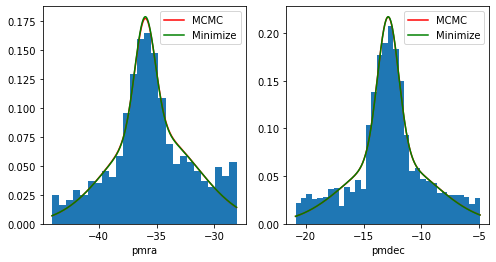

In [196]:
sample_data = df.pmra
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
bin_heights, bin_borders, _ = plt.hist(sample_data, bins='auto',
                                       range=(min(sample_data),max(sample_data)),density=True)
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
x = np.linspace(bin_borders[0], bin_borders[-1], 10000)
plt.plot(x, gaussian_function(x, params_mcmc_pmra), label='MCMC',color='red')
plt.plot(x, gaussian_function(x, results_pmra.x), label='Minimize', color='green')
plt.legend()
plt.xlabel('pmra')

plt.subplot(1,2,2)
sample_data = df.pmdec
bin_heights, bin_borders, _ = plt.hist(sample_data, bins='auto',
                                       range=(min(sample_data),max(sample_data)),density=True)
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
x = np.linspace(bin_borders[0], bin_borders[-1], 10000)
plt.plot(x, gaussian_function(x, params_mcmc_pmdec), label='MCMC',color='red')
plt.plot(x, gaussian_function(x, results_pmdec.x), label='Minimize',color='green')
plt.legend()
plt.xlabel('pmdec')

# 2D Gaussian function

In [197]:
def log_prior(params):
    nc, s, sx, sy, rho, mu_xc, mu_yc, mu_xf, mu_yf = params
    if 0.0 < nc < 1.0 and 0.0 < s < 10.0 and 0.0 < sx < 10.0 and 0.0 < sy < 10.0 and -1.0 < rho < 1.0:
        return 0.0
    return -np.inf

def log_likelihood(params, x, y):
    nc, s, sx, sy, rho, mu_xc, mu_yc, mu_xf, mu_yf = params
    amp_circ = nc / (2 * np.pi * s**2)
    amp_elip = (1-nc) / (2 * np.pi * sx * sy * np.sqrt(1 - rho**2))
    Exp_circ = -0.5 * (((x - mu_xc)/s)**2 + ((y - mu_yc)/s)**2)
    Exp_elip = -1/(2*(1-rho**2))*(((x - mu_xf)/sx)**2+((y - mu_yf)/sy)**2-2*rho*((x - mu_xf)/sx)*((y - mu_yf)/sy))
    z = amp_circ * np.exp(Exp_circ) + amp_elip * np.exp(Exp_elip)
    # Calculate log likelihood
    return np.sum(np.log(z))

def log_probability(params, x, y):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, x, y)

In [198]:
def Metropolis(params, X, Y, a = 0.1, NSteps = int(3e4)):
    
    x = np.ones(( NSteps, len(params) ))
    x[0] = params
    for i in tqdm(range(1, NSteps)):
        nc = x[i-1,0] + a * np.random.normal(loc=0, scale=1.0)
        s = x[i-1,1] + a * np.random.normal(loc=0, scale=1.0)
        sx = x[i-1,2] + a * np.random.normal(loc=0, scale=1.0)
        sy = x[i-1,3] + a * np.random.normal(loc=0, scale=1.0)
        rho = x[i-1,4] + a * np.random.normal(loc=0, scale=1.0)
        mu_xc = x[i-1,5] + a * np.random.normal(loc=0, scale=1.0)
        mu_yc = x[i-1,6] + a * np.random.normal(loc=0, scale=1.0)
        mu_xf = x[i-1,7] + a * np.random.normal(loc=0, scale=1.0)
        mu_yf = x[i-1,8] + a * np.random.normal(loc=0, scale=1.0)
        
        present = log_probability(params, X, Y)
        
        future = log_probability([nc, s, sx, sy, rho, mu_xc, mu_yc, mu_xf, mu_yf], X, Y)

        alpha = np.minimum(1, np.exp( future - present ))
        g = np.random.rand()
        
        if alpha > g:
            x[i,0] = nc
            x[i,1] = s
            x[i,2] = sx
            x[i,3] = sy
            x[i,4] = rho
            x[i,5] = mu_xc
            x[i,6] = mu_yc
            x[i,7] = mu_xf
            x[i,8] = mu_yf
        else:
            x[i,:] = x[i-1,:]       
         
    return x[100:,:] # quemamos los primeros xxxx puntos

In [199]:
x = df.pmra
y = df.pmdec
#nc, s, sx, sy, rho, mu_xc, mu_yc, mu_xf, mu_yf
rho_matrix = np.corrcoef(df.pmra, df.pmdec)
initparams = [0.5, results_pmra.x[1], results_pmra.x[2], results_pmdec.x[2], rho_matrix[0][1],
       results_pmra.x[3], results_pmdec.x[3], results_pmra.x[4], results_pmdec.x[4]]
print(initparams)
print(log_likelihood(initparams, x, y))
print(log_prior(initparams))
print(log_probability(initparams, x, y))

nll = lambda *args: -log_likelihood(*args)

results = minimize(nll, initparams, args=(x, y), options={"disc":True}, method='Nelder-Mead')
results.x

[0.5, 0.8728111473865305, 3.9392278568032992, 3.9258259574792103, 0.0961914881430311, -35.99260613407059, -12.874652338504744, -35.36842134377264, -12.756742542363725]
-9650.850143196772
0.0
-9650.850143196772


array([  0.34635535,   0.96613594,   4.25737434,   3.94115491,
         0.09760613, -35.96826931, -12.85916924, -35.26174904,
       -12.76398261])

In [166]:
x = df.pmra
y = df.pmdec
initparams = results.x
MCMC = Metropolis(initparams, x, y, 0.02, 500000)

100%|██████████| 499999/499999 [59:40<00:00, 139.64it/s]  


Minimize: [  0.34635535   0.96613594   4.25737434   3.94115491   0.09760613
 -35.96826931 -12.85916924 -35.26174904 -12.76398261]
MCMC:     [  0.34589337   0.96920177   4.26916319   3.9506003    0.09713986
 -35.96580994 -12.86037091 -35.28522167 -12.7659069 ]


Text(0.5, 0, 'step number')

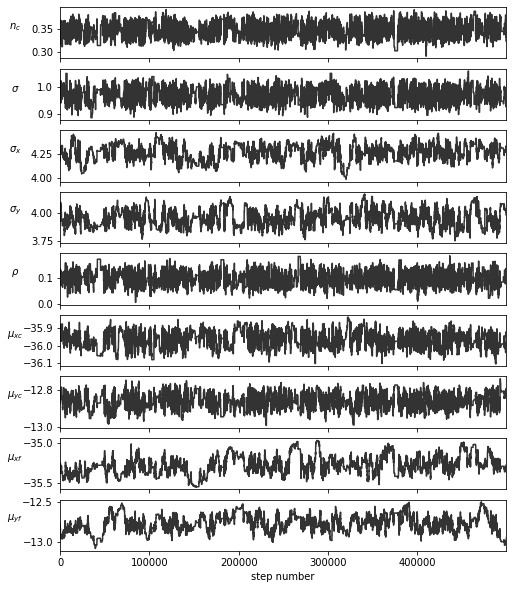

In [200]:
params_mcmc = np.percentile(MCMC ,50, axis=0)
print('Minimize:',results.x)
print('MCMC:    ',params_mcmc)

fig, axes = plt.subplots(len(params_mcmc), figsize=(8, 10), sharex=True)
labels = ["$n_c$", "$\sigma$", "$\sigma_x$", "$\sigma_y$", "$\\rho$",
          "$\mu_{xc}$", "$\mu_{yc}$", "$\mu_{xf}$", "$\mu_{yf}$"]
for i in range(len(params_mcmc)):
    ax = axes[i]
    ax.plot(MCMC[:,i], "k", alpha=0.8)
    ax.set_xlim(0, len(MCMC))
    ax.set_ylabel(labels[i],rotation=0)
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number")

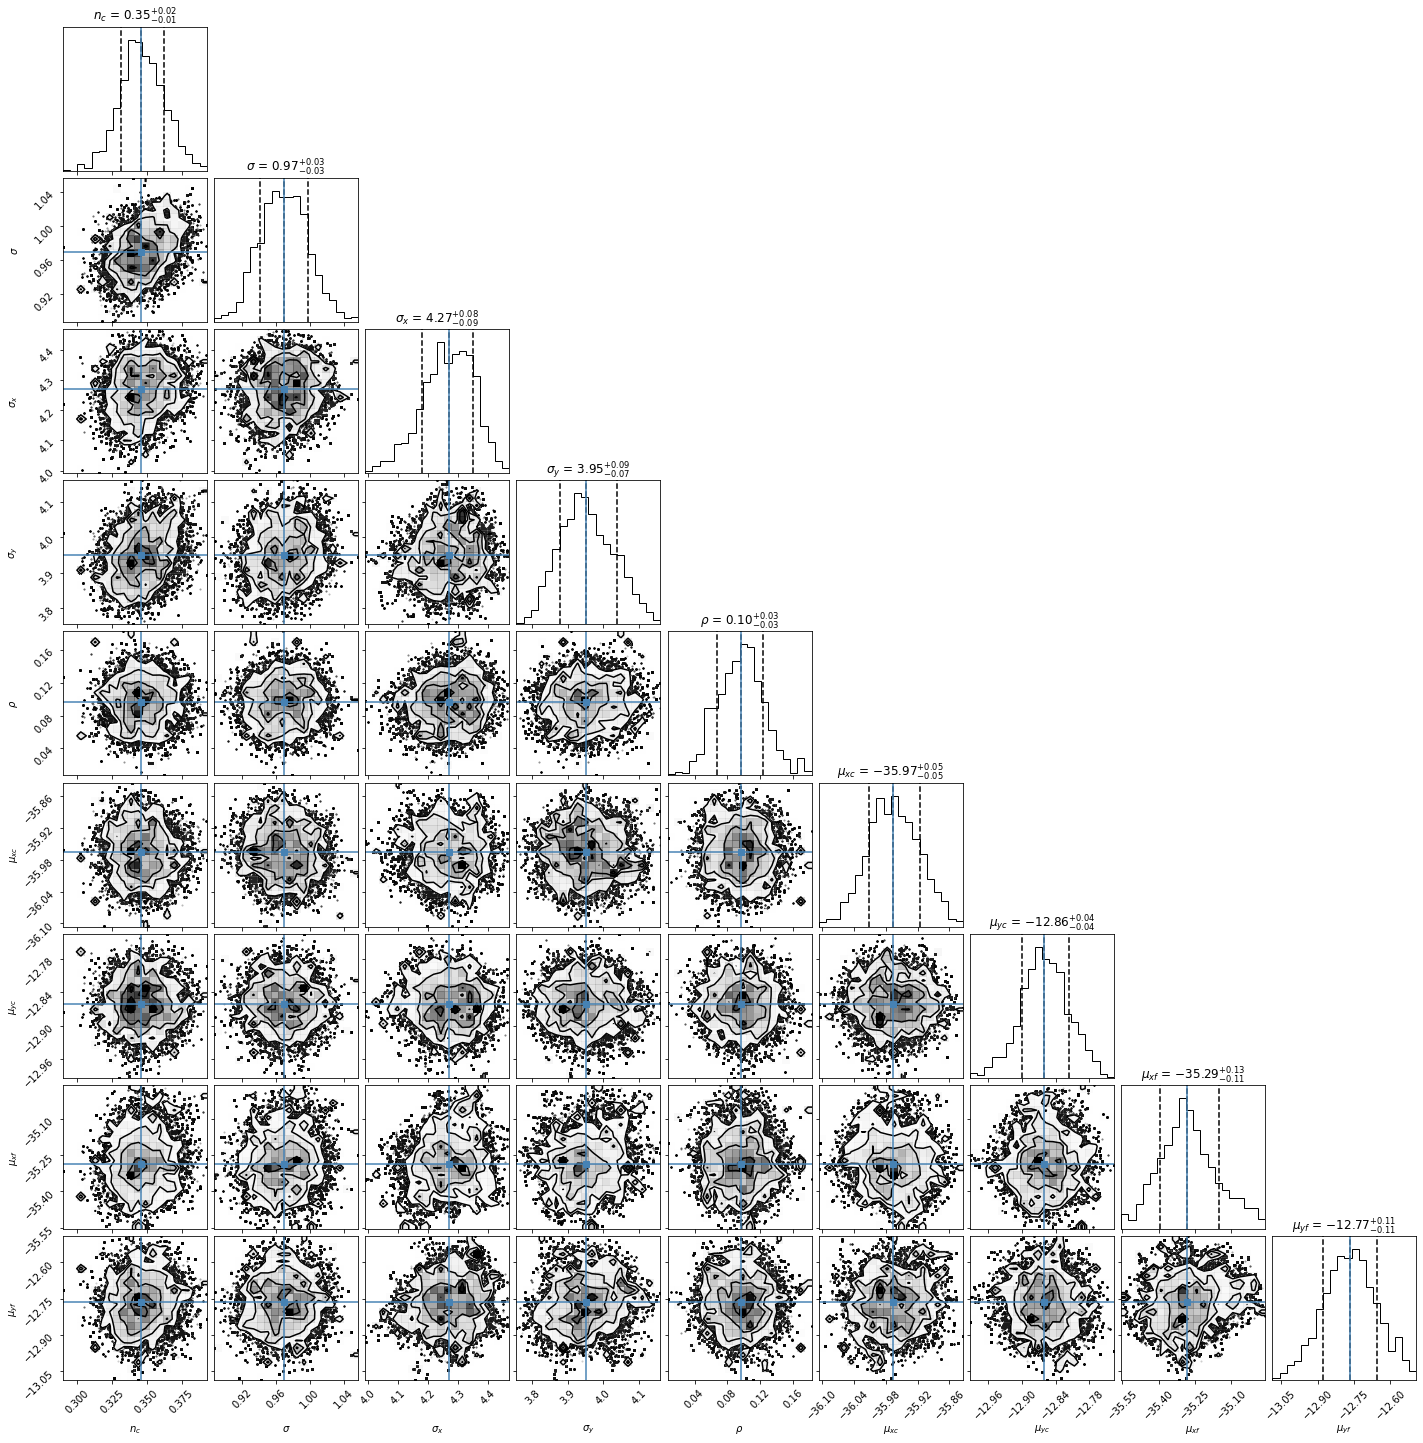

In [201]:
truths = np.percentile(MCMC ,50, axis=0)
#nc, s, sx, sy, rho, mu_xc, mu_yc, mu_xf, mu_yf
labels = ["$n_c$", "$\sigma$", "$\sigma_x$", "$\sigma_y$", "$\\rho$",
          "$\mu_{xc}$", "$\mu_{yc}$", "$\mu_{xf}$", "$\mu_{yf}$"]
figure = corner.corner(MCMC, labels=labels, truths=truths, quantiles=[0.16, 0.5, 0.84], show_titles=True,
                      title_kwargs={"fontsize": 12})
#plt.savefig('./corner_nine_parameters.jpg',bbox_inches = "tight")

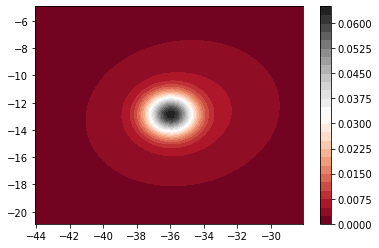

In [203]:
x = np.linspace(min(df.pmra), max(df.pmra), 50)
y = np.linspace(min(df.pmdec), max(df.pmdec), 50)

def func(x, y, params):
    nc, s, sx, sy, rho, mu_xc, mu_yc, mu_xf, mu_yf = params
    amp_circ = nc / (2 * np.pi * s**2)
    amp_elip = (1-nc) / (2 * np.pi * sx * sy * np.sqrt(1 - rho**2))
    Exp_circ = -0.5 * (((x - mu_xc)/s)**2 + ((y - mu_yc)/s)**2)
    Exp_elip = -1/(2*(1-rho**2))*(((x - mu_xf)/sx)**2+((y - mu_yf)/sy)**2-2*rho*((x - mu_xf)/sx)*((y - mu_yf)/sy))
    z = amp_circ * np.exp(Exp_circ) + amp_elip * np.exp(Exp_elip)
    return z

X, Y = np.meshgrid(x, y)
Z = func(X, Y, results.x)

plt.contourf(X, Y, Z, 30, cmap='RdGy')
plt.colorbar()
#plt.xlim(16,22)
#plt.ylim(0,5)

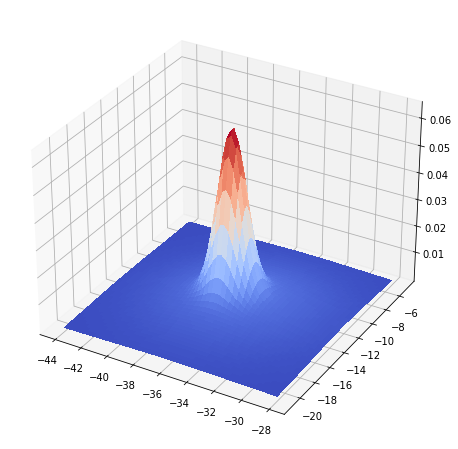

In [204]:
from matplotlib import cm
fig, ax = plt.subplots(subplot_kw={"projection": "3d"},figsize=(8, 8))
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,linewidth=0, antialiased=False)

0.9053977244182012


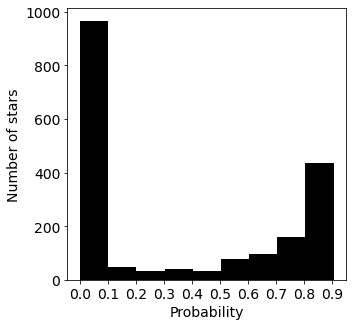

In [205]:
#nf, s, sx, sy, rho, mu_xc, mu_yc, mu_xf, mu_yf = truths
nc, s, sx, sy, rho, mu_xc, mu_yc, mu_xf, mu_yf = results.x

def probabilidad_circ(xy, nc, s, mu_xc, mu_yc):
    x, y = xy
    amp_circ =  1 / (2 * np.pi * s**2)
    Exp_circ = - 1/2 * (((x - mu_xc)/s)**2 + ((y - mu_yc)/s)**2)
    return nc * amp_circ * np.exp(Exp_circ)

def probabilidad_elip(xy, nc, sx, sy, rho, mu_xf, mu_yf):
    x, y = xy
    amp_elip = 1 / (2 * np.pi * sx * sy * np.sqrt(1 - rho**2))
    Exp_elip = - 1/(2*(1-rho**2))*(((x - mu_xf)/sx)**2+((y - mu_yf)/sy)**2-2*rho*((x - mu_xf)/sx)*((y - mu_yf)/sy))
    return (1-nc) * amp_elip * np.exp(Exp_elip)

xy = np.vstack((df.pmra, df.pmdec))
param_circ_prob = (nc, s, mu_xc, mu_yc)
param_elip_prob = (nc, sx, sy, rho, mu_xf, mu_yf)
p_circ = probabilidad_circ(xy, *param_circ_prob)
p_elip = probabilidad_elip(xy, *param_elip_prob)
prob = p_circ / (p_circ + p_elip)
#print('Min: {:.10f} Max: {:.10f}'.format(min(prob), max(prob)))
prob_limit = 0.5
members = (prob >= prob_limit)
no_members = (prob < prob_limit)
print(max(prob))
plt.figure(figsize=(5,5))
#plt.hist(prob, bins=5,range=[min(prob), 0.5], label='Field stars',color='gray')
#plt.hist(prob[(prob > 0.5)], bins=5,color='cyan',label='Cluster stars')
plt.hist(prob, bins=9,range=[min(prob), max(prob)],color='black')#histtype='step'
plt.xlabel('Probability',fontsize=14)
plt.ylabel('Number of stars',fontsize=14)
plt.xticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)
#plt.axvline(x = 0.5, color = 'black', label = 'Cut off', linestyle = '--')
#plt.legend()
#plt.savefig('./results/pleiades_probabilities.jpg',bbox_inches = "tight")
plt.show()

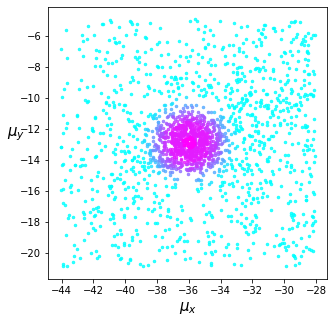

In [206]:
#colors=['black','dimgray','darkgrey','gainsboro','wheat','rosybrown','lightcoral','indianred','salmon','red']
#loop = np.arange(0.0, 1.0, 0.1)
loop = np.arange(0.0, 1.0, 0.1)
colors = [plt.cm.cool(each) for each in np.linspace(0, 1, len(loop))]

plt.figure(figsize=(5,5))
for i,c in zip(loop, colors):
  cond = (prob >= i) & (prob < i + 0.1)
  pmra_, pmdec_ = df.pmra[(cond)], df.pmdec[(cond)]
  plt.plot(pmra_, pmdec_,marker='.',c=c,linestyle='None',markersize=5,alpha=0.8)
plt.xlabel("$\mu_{x}$", fontsize = 15)
plt.ylabel("$\mu_{y}$", fontsize = 15,rotation=0)
#plt.savefig('./VPDClasses.jpg')
plt.show()

In [212]:
df['probability'] = prob
m44_members = df[members]
m44_members.to_csv('./beehive_PMmodel.csv')
print(len(m44_members))
m44_members

774


,source_id,ra,ra_error,dec,dec_error,parallax,parallax_error,pmra,pmra_error,pmdec,...,g,g_error,rp,rp_error,bp,bp_error,rv,rv_error,ruwe,probability
606,686562105793839488,134.871532,0.043838,23.227133,0.023411,0.004355,0.000056,-35.273022,0.053545,-12.589690,...,16.184465,3.030046,15.040220,13.612333,17.527868,8.736464,0.000000,0.000000,0.998989,0.875700
685,686585397400693760,134.549079,0.399526,23.515403,0.201602,0.005407,0.000484,-35.703967,0.461963,-14.650769,...,19.955772,0.656005,19.831284,6.251777,20.122845,6.580058,0.000000,0.000000,1.035697,0.647615
3106,687437003515673472,138.745317,0.160645,23.774139,0.112836,0.006111,0.000181,-36.062678,0.217768,-14.642174,...,17.994520,1.870738,16.758158,9.921955,19.667614,13.735422,0.000000,0.000000,1.076453,0.660407
3107,687437007811705728,138.743828,0.089147,23.770636,0.059810,0.005961,0.000105,-36.142683,0.120464,-14.643184,...,17.300758,2.200867,16.090551,17.375135,18.907928,9.084361,0.000000,0.000000,0.955390,0.658056
3956,687858636161318144,138.946341,0.257946,25.159136,0.202052,0.008070,0.000486,-35.661251,0.420309,-11.830592,...,18.514076,7.286453,16.011757,261.608920,17.202574,114.527230,0.000000,0.000000,0.969028,0.841160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75349,606157019476997760,137.850123,0.057177,13.315161,0.038971,0.005081,0.000073,-36.538219,0.075006,-13.550947,...,16.693779,2.432654,15.566793,10.198008,18.017006,8.100107,0.000000,0.000000,1.054601,0.867427
77638,604037985692543616,134.943616,0.106240,11.806051,0.074537,0.004430,0.000133,-37.487142,0.136639,-14.285852,...,17.911840,1.708225,16.650723,6.974502,19.665728,6.124672,0.000000,0.000000,0.974869,0.529062
78485,607223477036452608,135.671858,0.013686,14.459610,0.009129,0.005063,0.000018,-35.995965,0.019220,-12.467160,...,10.578259,158.733030,10.149335,139.395580,10.845507,174.069950,15.732321,0.226714,1.030258,0.898946
79335,610696452016191232,135.319609,0.083720,16.096254,0.053325,0.004310,0.000106,-36.652554,0.103892,-12.918784,...,17.414545,1.987303,16.224775,9.554013,18.958700,8.179525,0.000000,0.000000,0.979473,0.885928


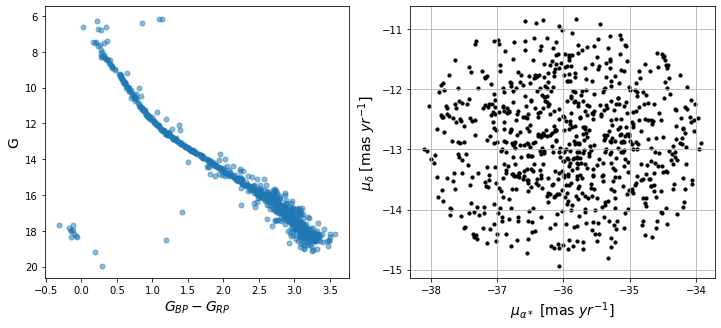

In [213]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
#plt.plot(pleiades['bp'] - pleiades['rp'], pleiades['g'],color='black',marker='.',linestyle='None',markersize=1,alpha=0.5)
plt.plot(m44_members['bp'] - m44_members['rp'], m44_members['g'],marker='o',linestyle='None',markersize=5,alpha=0.5)
#plt.text(4.2, 5.5, 'Pleiades',fontsize=15)
plt.xlabel("$G_{BP}-G_{RP}$", fontsize = 14)
plt.ylabel("G", fontsize = 14)
plt.gca().invert_yaxis()
#plt.savefig('./images_pm/pleiades_CMD_pm.jpg',bbox_inches = "tight")

plt.subplot(1,2,2)
#plt.plot(m44['pmra'], m44['pmdec'], color = 'black', marker = '.',linestyle = 'None', markersize = 1, alpha = 1)
plt.scatter(m44_members['pmra'], m44_members['pmdec'], color = 'black', marker = 'o', s = 10, alpha = 1)
plt.xlabel('$\mu_{\\alpha *}$ [mas $yr^{-1}$]',  fontsize = 14)
plt.ylabel("$\mu_{\delta}$ [mas $yr^{-1}$]",  fontsize = 14)
#plt.yticks([0.5, 1.5, 2.5, 3.5, 4.5],fontsize=14)
#plt.xticks([17, 18, 19, 20, 21],fontsize=14)
plt.grid()
#plt.savefig('./images_pm/pleiades_vpd_pm.jpg',bbox_inches = "tight")
plt.show()

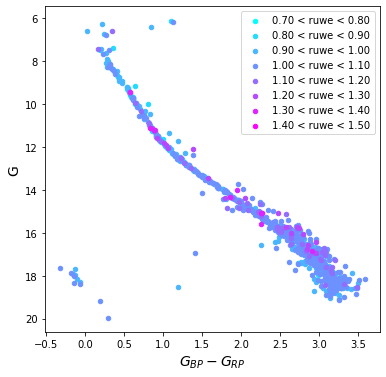

In [214]:
loop = np.arange(0.7, 1.5, 0.1)
colors = [plt.cm.cool(each) for each in np.linspace(0, 1, len(loop))]
plt.figure(figsize=(6,6))
for i,c in zip(loop, colors):
  cond = (m44_members.ruwe >= i) & (m44_members.ruwe < i + 0.1)
  color, g_mag = m44_members['bp'][(cond)]-m44_members['rp'][(cond)], m44_members['g'][(cond)]
  plt.scatter(color, g_mag,marker='o',color=c,s=20,alpha=1,label='{:.2f} < ruwe < {:.2f}'.format(i,i+0.1))
plt.gca().invert_yaxis()
plt.legend(fontsize = 10)
plt.xlabel("$G_{BP}-G_{RP}$", fontsize = 14)
plt.ylabel("G", fontsize = 14)
#plt.savefig('./results/pleiades_cmd_ruwe.jpg',bbox_inches = "tight")
plt.show()

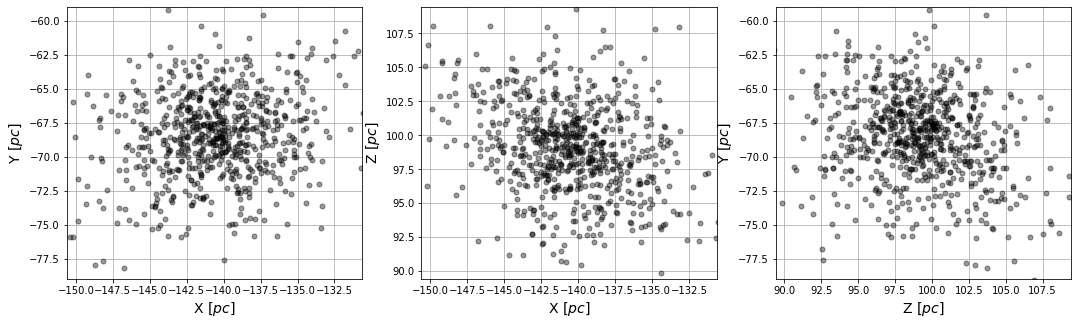

In [215]:
import astropy.units as u
import astropy.coordinates as apycoords

df_test = m44_members

ra_ = df_test['ra'] *u.deg
dec_ = df_test['dec'] *u.deg
distance_ = np.array(1/df_test['parallax']) *u.pc

c = apycoords.SkyCoord(ra=ra_,dec=dec_,distance=distance_,frame='icrs')
#print("(X,Y,Z) in (kpc,kpc,kpc)")
#print("\t",c.galactic.cartesian)
x = c.galactic.cartesian.x
y = c.galactic.cartesian.y
z = c.galactic.cartesian.z

xp = np.mean(x.to_value())
yp = np.mean(y.to_value())
zp = np.mean(z.to_value())
value = 10

%matplotlib inline
plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
plt.plot(x, y,color='k',marker='o',linestyle='None',markersize=5,alpha=0.4)
plt.xlim(xp - value,xp + value)
plt.ylim(yp - value,yp + value)
plt.xlabel("X $[pc]$", fontsize = 14)
plt.ylabel("Y $[pc]$", fontsize = 14)#,rotation=0)
plt.grid()

plt.subplot(1,3,2)
plt.plot(x, z,color='k',marker='o',linestyle='None',markersize=5,alpha=0.4)
plt.xlim(xp - value,xp + value)
plt.ylim(zp - value,zp + value)
plt.xlabel("X $[pc]$", fontsize = 14)
plt.ylabel("Z $[pc]$", fontsize = 14)#,rotation=0)
plt.grid()

plt.subplot(1,3,3)
plt.plot(z, y,color='k',marker='o',linestyle='None',markersize=5,alpha=0.4)
plt.xlim(zp - value,zp + value)
plt.ylim(yp - value,yp + value)
plt.xlabel("Z $[pc]$", fontsize = 14)
plt.ylabel("Y $[pc]$", fontsize = 14)#,rotation=0)
plt.grid()
#plt.savefig('./results/distribucion_espacial_test.jpg')
plt.show()